# Unit 5B - Variational autoencoders

### Bibliography 

Commented bibliography:
* _Chollet - Deep Learning with python_: a section on variational autoencoders vs GANs as tools to generate images
* _Buduma - Fundamentals of Deep learning - 2nd Ed_: it has a chapter on "generative models" that explains autoencoders (including variational autoencoders and denoising) and GANs. Very theoretical, with many formulas and a short example of implementation in pytorch.
* _Foster_ - _Generative Deep Learning_: a chapter on variational autoencoders. The chapter is divided into two parts: autoencoders in general and variational autoencoders (more deeply). Good examples around an art gallery run by two brothers (N. Coder and D. Coder).
* _Géron_ - _Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow - 2nd Ed_: a long chapter on autoencoders and GANS. It covers everything: convolutional, recurrent, denoising, sparse and variational autoencoders.



## 5B.1 Introduction

In the last years, *deep learning generative models* have gained more and more interest. Among these models, two families stand out:
* Generative Adversarial Networks (GANs)
* Variational Autoencoders (VAEs)

A VAE is an autoencoder where the latent space has some properties that allow us to generate data in a proper way. This is fundamental differences with the rest of autoencoders we studied in the last unit.

An autoencoder is a encoder (sample to latent space) followed by a decoder (latent space to sample). One could think that, if we take a random point from the latent space, we could decode this point to generate new content. However, this depend on three factors:
* Distribution of data
* Dimension of the latent space
* Architecture of the AE
Then, we can not ensure that the latent space is adequate to generate content as described.

Lets suppose that the training set has N multidimensional samples, and that an AE is trained that encodes this data into the real axis (the dimension of the latent space is one). We could even think of an AE that implements the identity function, where each training sample would correspond to a point in the real axis. This would imply that most of the latent space would be meaningless. 

<p style="text-align: center; background-color: #ffffff"> <img src="U5B-images/AEoverfitting.webp" alt="drawing" width="80%"/>

This is what happens with autoencoders: their goal is to encode and decode with the minimum losses, and not to organize the latent space in any way. If we want to use AEs to generate data, we have to assure that the latent space is well organized with a regularization function that penalizes a disorganized latent space.
    
Let's check the organization of the latent space of the undercomplete autoencoder from unit 5A


Train: (60000, 784)  - Test: (10000, 784)


2023-03-25 12:57:31.350242: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 12:57:32.121234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22291 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2023-03-25 12:57:32.122324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22225 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 2)                 213394    
                                                                 
 decoder (Sequential)        (None, 784)               214176    
                                                                 
Total params: 427,570
Trainable params: 427,570
Non-trainable params: 0
_________________________________________________________________


2023-03-25 12:57:33.242026: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


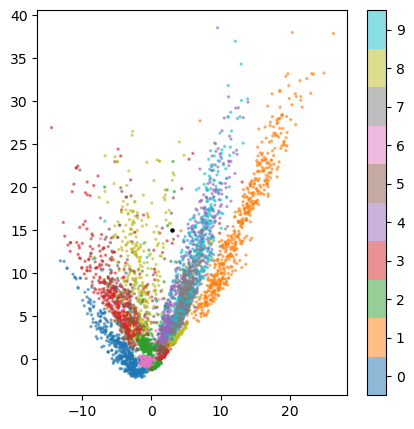

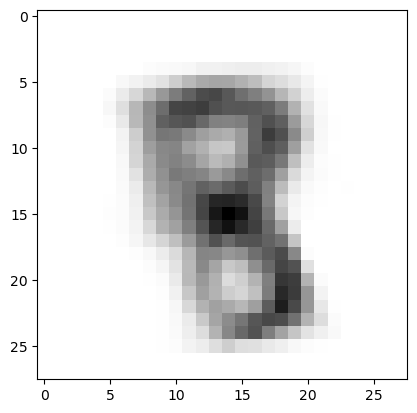

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train=x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test=x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

print("Train:",x_train.shape, " - Test:", x_test.shape)


import tensorflow as tf
AE = tf.keras.models.load_model('U5A-models/UndercompleteAE.h5')
AE.layers[0]._name="encoder"
AE.layers[1]._name="decoder"
AE.summary()
encoderAE = AE.layers[0]
decoderAE = AE.layers[1]

n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_train)), n_to_show)
example_images = x_train[example_idx]
example_labels = y_train[example_idx]

z_points_ae = encoderAE.predict(example_images)
test_point = tf.constant([3, 15],shape=(1,2))
# print(test_point)

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(z_points_ae[:, 0] , z_points_ae[:, 1] , cmap='tab10',  c=example_labels, alpha=0.5, s=2)
plt.colorbar(values=range(10), ticks=range(10))
plt.scatter(test_point[0,0], test_point[0,1], s=5, c='black')

test_image=decoderAE.predict(test_point)

fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.imshow(test_image.reshape((28,28)), cmap='binary')
plt.show()


In order to use the autoencoder for generation, the latent space should be regular enough. This is the idea behind variational autoencoders: the training is regularised to avoid overfitting and to ensure that the latent space has good properties.

In variational AE, instead of encoding the input as a single point, it is enconded as a distribution over a latent space. The training process is:
1. The input is encoded as a distribution over the latent space
1. A point is sampled from this distribution
1. The point is decoded and the reconstruction error is computed
1. The reconstruction error is backpropagated through the NN

The difference between training an AE and training a VAE is summarized in the following plot:

<p style="text-align: center; background-color: #ffffff"> <img src="U5B-images/TrainingAEvsVAE.webp" alt="drawing" width="60%"/>

The output of the encoder is a $q(z) = p(z|x)$ is a multivariate gaussian that represents a compressed version of the input. The dimension of the multivariate gaussian is the dimension of the latent space.

While a Simple Autoencoder learns to map each image to a fixed point in the latent space, the Encoder of a Variational Autoencoder (VAE) maps each image to a z-dimensional standard normal distribution.

__How can a simple autoencoder be modified to make the encoder map to a multi-dimensional standard normal distribution?__

A multidimensional normal distribution can be represented by a mean vector $\mu$ and a covariance matrix $\Sigma$:

$$\mu = \begin{pmatrix}
\mu_1 \\
\mu_2 \\
\vdots \\
\mu_n 
\end{pmatrix} \quad \quad \Sigma = \begin{pmatrix}
\sigma^2_1 & \rho \sigma_1 \sigma_2 & \cdots & \rho \sigma_1 \sigma_n \\
\rho \sigma_2 \sigma_1 & \sigma^2_2 & \cdots & \rho \sigma_2 \sigma_n \\
\vdots  & \vdots  & \ddots & \vdots  \\
\rho \sigma_n \sigma_1 & \rho \sigma_n \sigma_2 & \cdots & \sigma^2_n \\ 
\end{pmatrix}
$$

It is assumed that there is no correlation between elements in the latent vector, so the non diagonal elements in $\Sigma$, that represent covariance, are all zeros and $\Sigma$ is diagonal:
$$
\Sigma = \begin{pmatrix}
\sigma^2_1 & 0 & \cdots & 0 \\
0 & \sigma^2_2 & \cdots & 0 \\
\vdots  & \vdots  & \ddots & \vdots  \\
0 & 0 & \cdots & \sigma^2_n \\ 
\end{pmatrix}
$$
which is normally represented by a vector:
$$\sigma^2 = \begin{pmatrix}
\sigma_1^2 \\
\sigma_2^2 \\
\vdots \\
\sigma_n^2 
\end{pmatrix}
$$

The variance cannot take negative values. So, the encoder is actually mapped to the mean vector and the __logarithm__ of the variance, which can take any value (negative or positive), and that ensures that the variance is a positive number.

__How can be ensured that the encoder maps to a stardard Normal distribution N(0,1)?__ The solution to this question is to introduce a regularization term based on the KL (Kullback-Leiber) divergence, that measures the distances between probability distributions.

$$ D_{KL}\left[N(\mu,\sigma)||N(0,1)\right] = \frac{1}{2} \Sigma^n_{i=1} \left( 1+log(\sigma^2_i) - \mu^2_i -\sigma^2_i \right)$$

The reconstruction error is going to have two components:
* A standard reconstruction error
* A regularization component term defined as the _Kulback-Leibler divergence_ between the distribution and the standard gaussian distribution $N(0,1)$.

$$Loss = L(x,\hat{x}) + D_{KL} $$

The mean and variance of the random distribution can be optimized in the backpropagation algorithm. However, backpropagation cannot be done for a sampling process of an arbitrary random distribution. This can be solved using the __reparametrization trick__:  we sample a hidden state $x$ via $x = \mu + \sigma  \times \epsilon$, where $\epsilon$ is a standard gaussian $N(0,1)$. Now the random node is not blocking the path for backpropagation for $\mu$ and $\sigma$.

<p style="text-align: center; background-color: #ffffff"> <img src="U5B-images/Reparametrization.jpg" alt="drawing" width="70%"/>



This regularization has two effects on the latent space:
* __Continuity__: two close points in the latent space should not give two completely different contents once decoded 
* __Completeness__: for a chosen distribution, a point sampled from the latent space should give _meaningful_ content once decoded

<p style="text-align: center; background-color: #ffffff"> <img src="U5B-images/RegularizedLatentSpace.webp" alt="drawing" width="50%"/>

This tends to create a "gradient" over the information encoded in the latent space:

<p style="text-align: center; background-color: #ffffff"> <img src="U5B-images/RegularizedLatentSpace2.webp" alt="drawing" width="40%"/>

Saving the mathematical formulation, the encoding and decoding process is summarized in the following plot:

<p style="text-align: center; background-color: #ffffff"> <img src="U5B-images/VAEscheme.webp" alt="drawing" width="50%"/>



## 5B.2 Implementation of a variational autoencoder

In this implementation, we will be using the MNIST dataset. First, we need to import the packages necessary to our environment:


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

Before defining the encoder and the decoder, we define the bottleneck layer of the architecture, that in this case is the _Sampling_ layer.

It is a new class derived from the _Layer_ class, which uses the output from two dense layers _z_mean_ and _z_log_var_ (implemented later) as input, and then converts them into a normal distribution. From this normal distribution, it samples a value that passes to the decoder layer.

In [3]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Now we define the encoder part of the VAE, that take images as input and encodes their representation in the Sampling layer.

The dimension of the latent space 2, but the output of the encoder consists of three sets of 2-dimensional vectors:
* The means (_z_mean_)
* The log-variances (_z_log_var_)
* The samples from the gaussian distribution defined by the means and the log-variances (_sampling_)

Note1: in this case we are using convolutional layers to reduce the dimensionality before the bottleneck

Note2: the tensorflow notation in this case is a little different. Instead of using the _add_ method to add layers, we define the input and apply layers defined as functions.

In [4]:
latent_dim = 2
 
encoder_inputs = Input(shape =(28, 28, 1))
x = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)
x = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Flatten()(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoderVAE = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoderVAE")
encoderVAE.summary()

Model: "encoderVAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                         

We define the decoder, that in this case is simpler than the encoder.  

In [5]:
latent_inputs = keras.Input(shape =(latent_dim, ))
x = Dense(7 * 7 * 64, activation ="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Conv2DTranspose(32, 3, activation ="relu", strides = 2, padding ="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation ="sigmoid", padding ="same")(x)
decoderVAE = Model(latent_inputs, decoder_outputs, name ="decoderVAE")
decoderVAE.summary()

Model: "decoderVAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        2

Both models are combined and the training procedure (with loss and regularization functions) is defined. It can be seen that the complete variational architecture is built by defining a class that is child of _keras.Model_. Both losses are returned by the method _train_step_. 

In [6]:
class VAE(keras.Model):
    def __init__(self, encoderVAE, decoderVAE, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoderVAE = encoderVAE
        self.decoderVAE = decoderVAE
 
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoderVAE(data)
            reconstruction = decoderVAE(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Now the database is loaded and the VAE is trained. 

In [7]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255
x_train=x_train.reshape((-1,28,28,1))

# compile and train the model
vae = VAE(encoderVAE, decoderVAE)
vae.compile(optimizer ='rmsprop')
vae.fit(x_train, epochs = 25, batch_size = 64)


Epoch 1/25


2023-03-25 12:58:07.648744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


938/938 [==============================] - 9s 7ms/step - loss: 184.9399 - reconstruction_loss: 182.3415 - kl_loss: 2.5984
Epoch 2/25
938/938 [==============================] - 7s 7ms/step - loss: 162.5908 - reconstruction_loss: 159.5074 - kl_loss: 3.0834
Epoch 3/25
938/938 [==============================] - 7s 7ms/step - loss: 157.8746 - reconstruction_loss: 154.6685 - kl_loss: 3.2061
Epoch 4/25
938/938 [==============================] - 7s 7ms/step - loss: 154.9868 - reconstruction_loss: 151.6796 - kl_loss: 3.3073
Epoch 5/25
938/938 [==============================] - 7s 7ms/step - loss: 153.1329 - reconstruction_loss: 149.7365 - kl_loss: 3.3964
Epoch 6/25
938/938 [==============================] - 7s 7ms/step - loss: 151.7772 - reconstruction_loss: 148.3409 - kl_loss: 3.4363
Epoch 7/25
938/938 [==============================] - 7s 7ms/step - loss: 150.8095 - reconstruction_loss: 147.3185 - kl_loss: 3.4910
Epoch 8/25
938/938 [==============================] - 7s 7ms/step - loss: 150.03

It can be seen that the latent space is much more regular than when we were training undercomplete AEs. 

The output of the decoder is a list of three elements:
* z_points[0] are the means
* z_points[1] are the log variances
* z_points[2] are the samples from the gaussian distribution

In this case, we are plotting the means, but the samples should give a plot with a similar aspect

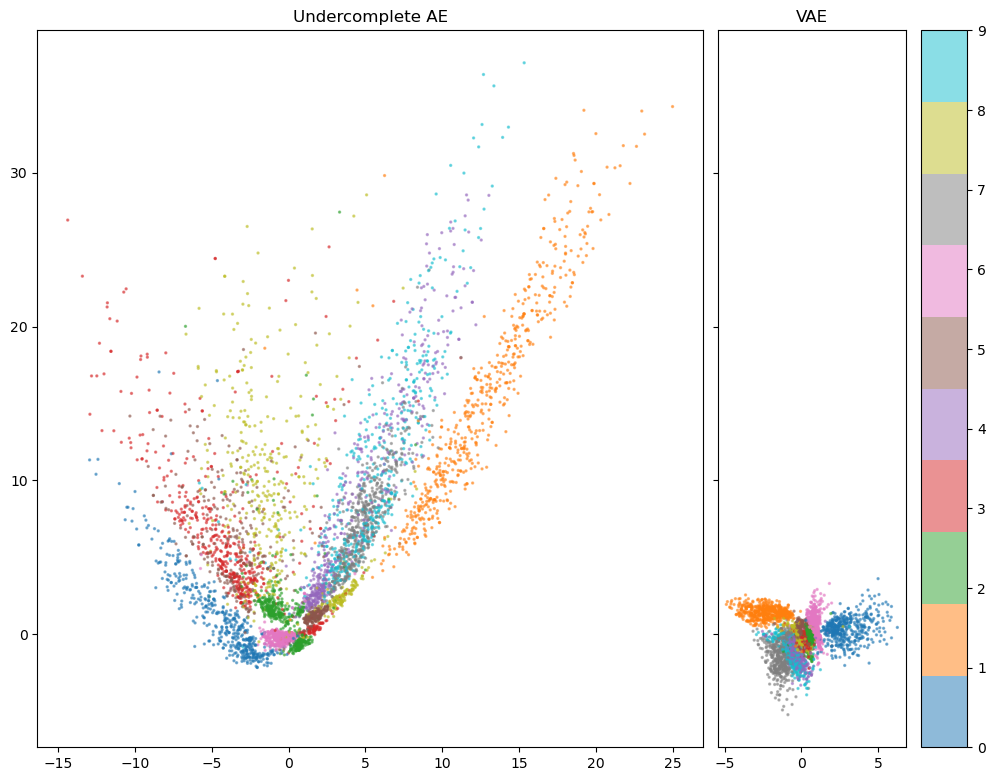

In [8]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_train)), n_to_show)
example_images = x_train[example_idx]
example_labels = y_train[example_idx]


z_points_ae = encoderAE.predict(example_images.reshape(-1, 784))
z_points_vae = encoderVAE.predict(example_images)

from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(12,24))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 #share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )


# grid[0].imshow(np.random.random((10,10)), vmin=0, vmax=1)
grid[0].scatter(z_points_ae[:, 0] , z_points_ae[:, 1] , cmap='tab10',  c=example_labels, alpha=0.5, s=2)
grid[0].set_title("Undercomplete AE")
im1 = grid[1].scatter(z_points_vae[0][:, 0] , z_points_vae[0][:, 1],
                      cmap='tab10',  c=example_labels, alpha=0.5, s=2)
grid[1].set_title("VAE")


# Colorbar
grid[1].cax.colorbar(im1)
grid[1].cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()




Finally, we are going to generate results according to their values in the latent space vectors (both for the AE and the VAE)

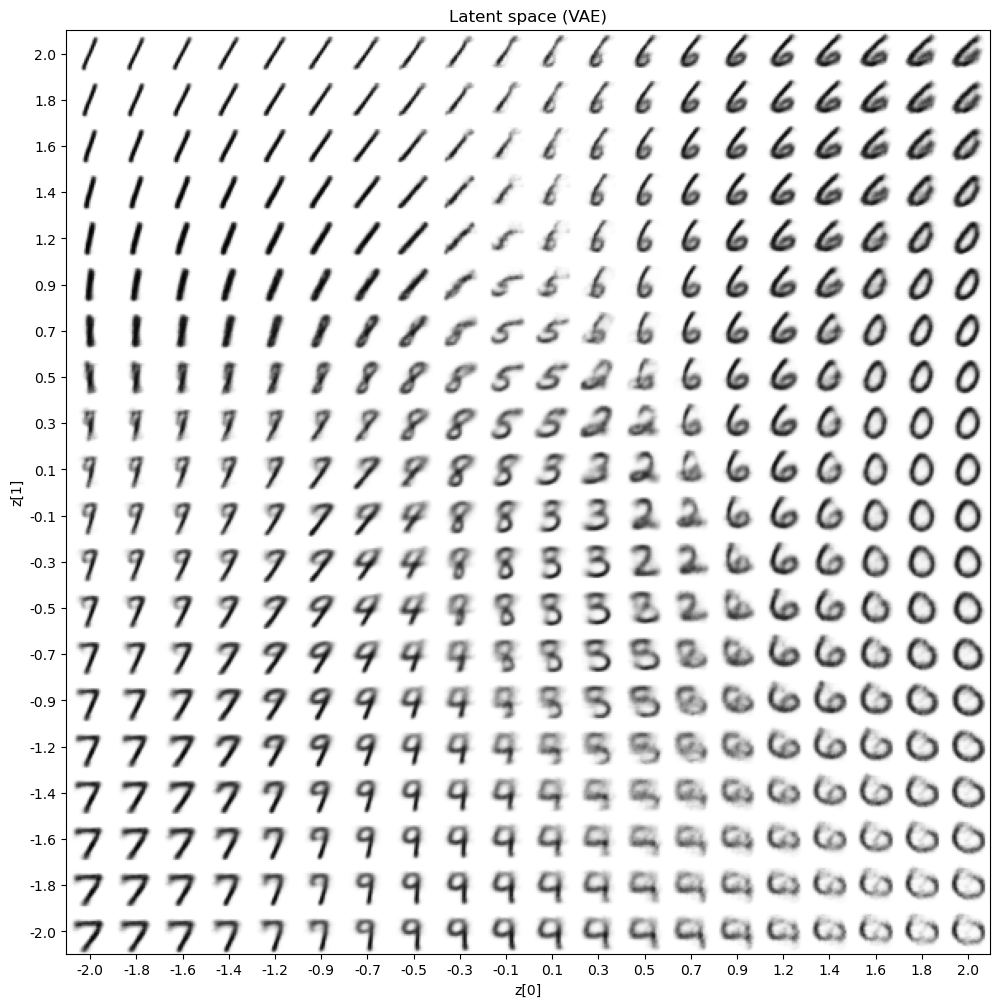

In [9]:
n = 20
img_dim = 28

xmin=-2
xmax=2
ymin=-2
ymax=2

figsize = 12
figure = np.zeros((img_dim * n, img_dim * n))
# linearly spaced coordinates corresponding to the 2D plot
# of images classes in the latent space
grid_x = np.linspace(xmin, xmax, n)
grid_y = np.linspace(ymin, ymax, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoderVAE.predict(z_sample)
        images = x_decoded[0].reshape(img_dim, img_dim)
        figure[
            i * img_dim : (i + 1) * img_dim,
            j * img_dim : (j + 1) * img_dim,
        ] = images

plt.figure(figsize =(figsize, figsize))
start_range = img_dim // 2
end_range = n * img_dim + start_range 
pixel_range = np.arange(start_range, end_range, img_dim)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
#plt.xticks(grid_x, grid_x)

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap ="binary")
plt.title("Latent space (VAE)")
plt.show()

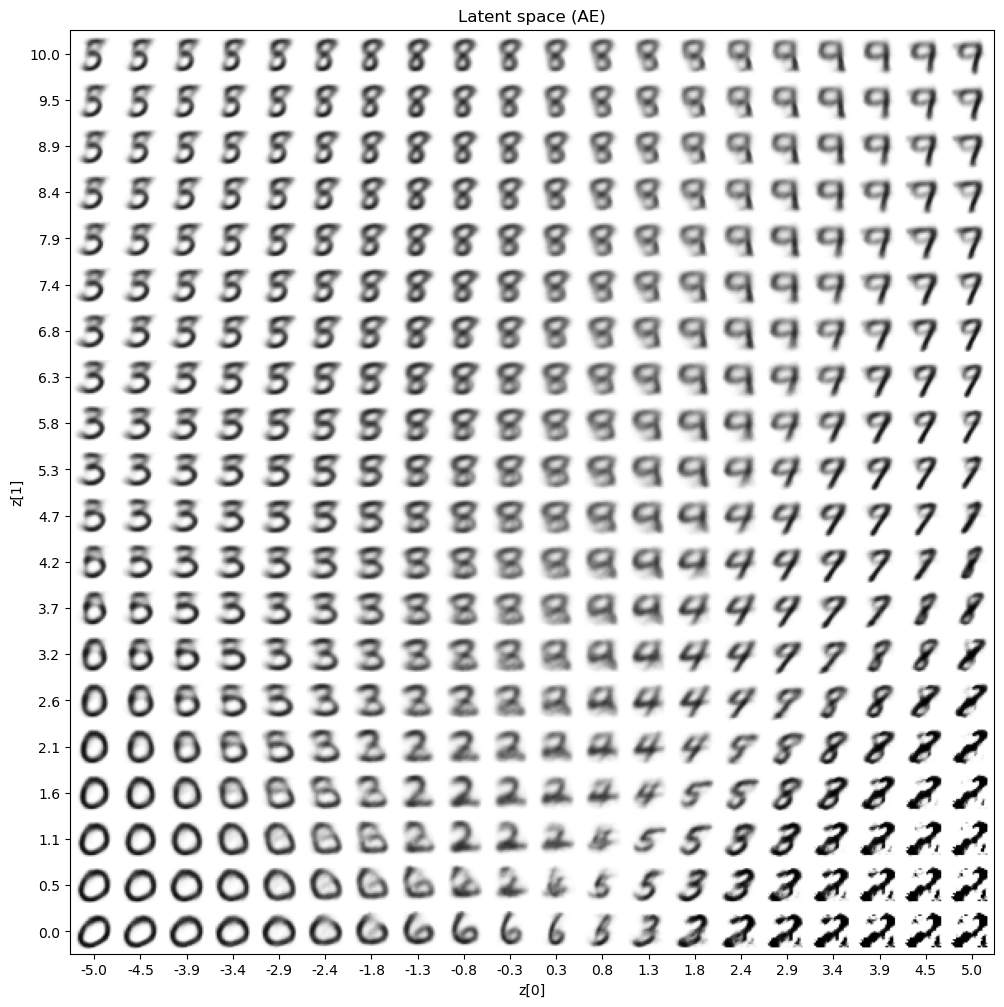

In [11]:
n = 20
img_dim = 28

xmin=-5
xmax=5
ymin=0
ymax=10

figsize = 12
figure = np.zeros((img_dim * n, img_dim * n))
# linearly spaced coordinates corresponding to the 2D plot
# of images classes in the latent space
grid_x = np.linspace(xmin, xmax, n)
grid_y = np.linspace(ymin, ymax, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoderAE.predict(z_sample)
        images = x_decoded[0].reshape(img_dim, img_dim)
        figure[
            i * img_dim : (i + 1) * img_dim,
            j * img_dim : (j + 1) * img_dim,
        ] = images

plt.figure(figsize =(figsize, figsize))
start_range = img_dim // 2
end_range = n * img_dim + start_range 
pixel_range = np.arange(start_range, end_range, img_dim)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
#plt.xticks(grid_x, grid_x)

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap ="binary")
plt.title("Latent space (AE)")
plt.show()

## 5B.3 Using AEs to generate new faces

As we now, both AEs and VAEs allow us to develop a low-dimensional __latent space__ of representations where any point can be mapped to a realistic looking sample (digit in the last section).

This process can be seen in the image:
<p style="text-align: center; background-color: #ffffff"> <img src="U5B-images/Generator.png" alt="drawing" width="60%"/>

A tool capable of taking a latent point and outputting a realistic image is generator, and two main families of NNs can be used for this task:
1. VAEs (Variational Autoencoders)
2. GANs (Generative Adversarial Networks)

These two are different strategies. VAEs create well structured latent spaces, where specific directions encode a meaningful axis of variation in the data. GANs create highly realistic images, but the latent space where they come from are not so structured and continuous.

First, we are going to use standard AEs, and then compare them against VAEs to generate new faces.

### The dataset

We are going to use the CelebA dataset (https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) from Kaggle. It contains 202599 faces images of celebrities.

First, the imports and some code to set some parameters:


In [1]:
# For using with https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

DATA_FOLDER = "/home/leandro/DL/Faces/img_align_celeba"
WEIGHTS_FOLDER = '/home/leandro/DL/Faces/weights/'

import numpy as np
import glob, os


if not os.path.exists(WEIGHTS_FOLDER):
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))


from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
#from keras.utils import plot_model

filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
# prints : Total number of images : 202599

2023-03-25 12:30:05.102728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total number of images : 202599


The dataset is rather large, so we are going to create and _ImageDataGenerator_ object (that is an _iterator_) and use its _flow_from_directory_ function instead of loading all the dataset.

In [2]:

INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)


data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training'
    )

Found 202599 images belonging to 1 classes.


### The encoder

The architecture of the encoder is a stack of convolutional layers followed by a dense layer with outputs a vector of size 200 into the bottleneck.

In [3]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
    
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)

    # Define model output
    encoder_output = Dense(output_dim, name = 'encoder_output')(x)

    return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    conv_filters = [32, 64, 64, 64],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

2023-03-25 12:30:14.983457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 12:30:14.984486: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### The decoder

The decoder reconstruct the image from the latent space gradually through the network. This is achieved by using _Conv2DTranspose_ layers. In this case the decoder is basically a mirror image of the encoder

In [4]:
# -----------------------------------------------
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = shape_before_flattening,
    conv_filters = [64,64,32,3],        
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 16, 16, 64)       36928     
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 32, 32, 64)       36928     
 pose)                                                     

### Attaching the encoder and the decoder

The input of the model is fed to the encoder and the output of the model is the output of the decoder. Then, both are used to define the model

In [5]:

simple_autoencoder_input = encoder_input

simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0   

### Compiling, training and saving the model

The loss function is RMSE (Root Mean Square Error). The Adam optimizer is used for encoding the batch of images into the latent space and decode them to reconstruct the images.

For practical reasons, the model is saved after the training, and the python session will be reset before the testing starts.

In [41]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

adam_optimizer = Adam(learning_rate = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=adam_optimizer, loss = r_loss)

simple_autoencoder.fit(data_flow, 
    shuffle=True, 
    epochs = N_EPOCHS, 
    initial_epoch = 0, 
    steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

simple_autoencoder.save(os.path.join(WEIGHTS_FOLDER, 'AE/model.h5'))


Epoch 1/10
395/395 [==============================] - 255s 635ms/step - loss: 0.0283
Epoch 2/10
395/395 [==============================] - 230s 582ms/step - loss: 0.0105
Epoch 3/10
395/395 [==============================] - 229s 580ms/step - loss: 0.0089
Epoch 4/10
395/395 [==============================] - 229s 579ms/step - loss: 0.0082
Epoch 5/10
395/395 [==============================] - 230s 580ms/step - loss: 0.0078
Epoch 6/10
395/395 [==============================] - 230s 581ms/step - loss: 0.0076
Epoch 7/10
395/395 [==============================] - 230s 580ms/step - loss: 0.0074
Epoch 8/10
395/395 [==============================] - 230s 581ms/step - loss: 0.0072
Epoch 9/10
395/395 [==============================] - 229s 579ms/step - loss: 0.0071
Epoch 10/10
395/395 [==============================] - 230s 581ms/step - loss: 0.0071


### Loading the model

As said before, the python sesion is supposed to have been reset. Then, we have to recover the model and rebuild the _ImageGenerator_ object.

In this case, we are loading the previously trained model (a _Functional_ model) and extracting its layers into two _Sequential_ models for the encoder and the decoder (they are going to be used in our tests). The _r_loss_ function has to be passed to the loading function, as it has been used in the definition of the model.

In [6]:
DATA_FOLDER = "/home/leandro/DL/Faces/img_align_celeba"
WEIGHTS_FOLDER = '/home/leandro/DL/Faces/weights/'

import os, glob
import numpy as np

import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.layers import Input, Flatten, Dense, Lambda
from keras.models import Model



filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
# prints : Total number of images : 202599


INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)


data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
        target_size = INPUT_DIM[:2],
        batch_size = BATCH_SIZE,
        shuffle = True,
        class_mode = 'input',
        subset = 'training'
        )


def r_loss(y_true, y_pred):
        return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

autoencoder = tensorflow.keras.models.load_model(os.path.join(WEIGHTS_FOLDER, 'AE/model.h5'), custom_objects={"r_loss": r_loss })

# autoencoder.summary()


encoder = tensorflow.keras.Sequential()
for layer in autoencoder.layers[0:11]:
    encoder.add(layer)

encoder.build()
encoder.summary()

decoder = tensorflow.keras.Sequential()
decoder.add(autoencoder.layers[-1])
decoder.build()
decoder.summary()

Total number of images : 202599
Found 202599 images belonging to 1 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0         
                                              

### Reconstructing images

The first step is to generate a batch of images. The images are returned as an array and the number of images is equal to BATCH_SIZE. We are showing only the first images from these batch.

1/1 [==============================] - 0s 52ms/step


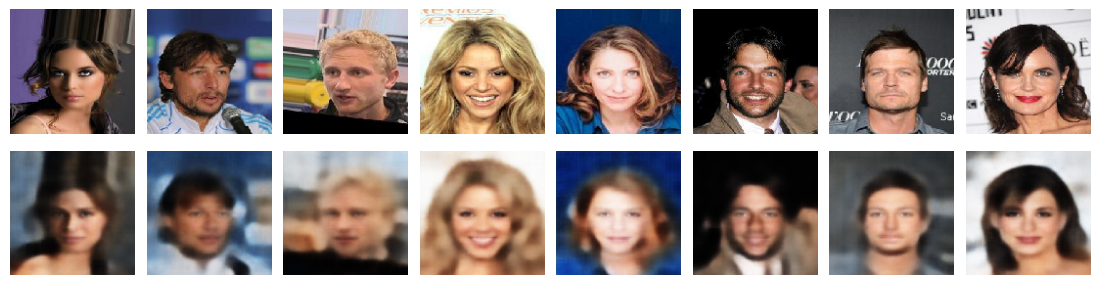

In [33]:

import matplotlib.pyplot as plt

example_batch = next(data_flow)
example_batch = example_batch[0]

def plot_compare(images, add_noise=False):
    
    n_to_show = images.shape[0]

    if add_noise:
        encodings = encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = decoder.predict(encodings)

    else:
        reconst_images = autoencoder.predict(images)


    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
        #img = images[i].squeeze()
        img = images[i]
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img)
    plt.show()

example_images = example_batch[:8]

plot_compare(example_images)  

The reason why the images lack sharpness is because RMSE averages out differences between individual pixels. The effect is that image is smoothed. 

### Main AEs drawbacks

If we add noise to the image encodings, it can be observed that the images start to get distorted. This is because the model does not ensure that the space around the encoded values in the latent spaces is continuous.

1/1 [==============================] - 0s 170ms/step


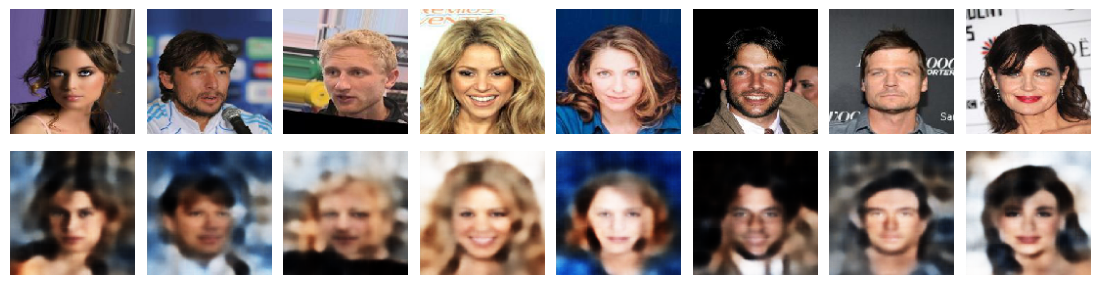

In [34]:
plot_compare(example_images, add_noise=True)  

We can try to generate random values in the latent space and use the decoder to create a new image from these values. 

1/1 [==============================] - 0s 36ms/step


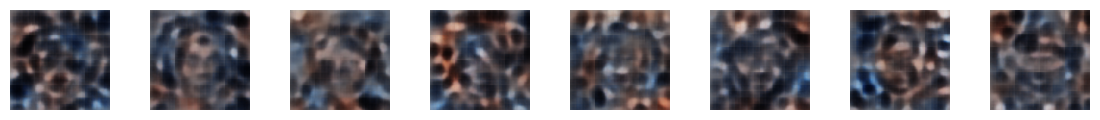

In [8]:

def generate_images_from_noise(n_to_show = 8): 
    reconst_images = decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.4, wspace=0.4)

    for i in range(n_to_show):
            img = reconst_images[i].squeeze()
            sub = fig.add_subplot(1, n_to_show, i+1)
            sub.axis('off')        
            sub.imshow(img)
    plt.show()

generate_images_from_noise()      


It is quite evident that this procedure cannot be used to generate new faces. The latent space is not centered around the origin and it is not continuous either. 

## 5B.4 Using VAEs to generate new faces

As explained previously, while a simple Autoencoder learns to map each image to a fixed point in the latent space, the encoder of a Variational Autoencoder (VAE) maps each image to a multi-dimensional standard normal distribution.

### The encoder

The encoder of the VAE is similar to the encoder of the AE, but it has now two additional outputs: mu ($\mu$, the mean) and log_var (the logarithm of the variance $\sigma$)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 64)   18496       ['leaky_re_lu[0][0]']        

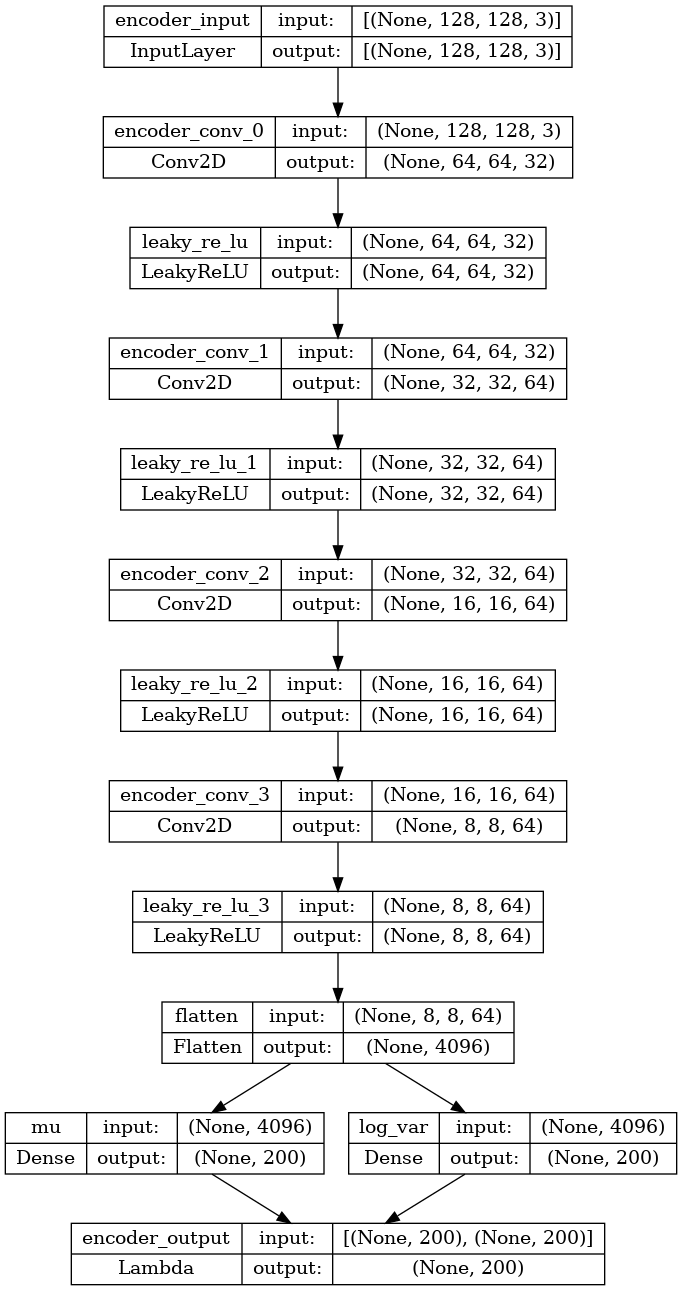

In [35]:
from keras.utils.vis_utils import plot_model
 
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer 
    # in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])


    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)


vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    conv_filters = [32, 64, 64, 64],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

vae_encoder.summary()

plot_model(vae_encoder, show_shapes=True, show_layer_names=True)


### The decoder

The decoder of the VAE is exactly the same as the AE

In [36]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,
    conv_filters = [64,64,32,3],        
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 16, 16, 64)       36928     
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 32, 32, 64)       36928     
 pose)                                                     

### Compiling, training and saving the model

As before, we attach the encoder and the decoder of the VAE

In [37]:

vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 64)   18496       ['leaky_re_lu[0][0]']      

For training, the loss function is a sum of RMSE and KL divergence. A weight (the loss factor) is assigned to the RMSE loss:
* If we use a high loss factor, the VAE would be similar to a simple AE
* If we use a low loss factor, the quality of the reconstructed images will be poor

As before, we save the model to a file

In [15]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

adam_optimizer = Adam(learning_rate = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)


vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

vae.fit(data_flow, 
    shuffle=True, 
    epochs = N_EPOCHS, 
    initial_epoch = 0, 
    steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

vae.save(os.path.join(WEIGHTS_FOLDER, 'VAE/model.h5'))


Epoch 1/200
2023-03-23 16:44:55.162389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2023-03-23 16:44:56.556902: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
395/395 [==============================] - 221s 551ms/step - batch: 197.5000 - size: 511.6136 - loss: 393.0904 - r_loss: 0.0346 - kl_loss: 46.7941
Epoch 2/200
395/395 [==============================] - 224s 566ms/step - batch: 197.5000 - size: 511.6136 - loss: 240.3283 - r_loss: 0.0184 - kl_loss: 55.9608
Epoch 3/200
395/395 [==============================] - 223s 564ms/step - batch: 197.5000 - size: 511.6136 - loss: 224.9553 - r_loss: 0.0167 - kl_loss: 57.9917
Epoch 4/200
395/395 [==============================] - 220s 555ms/step - batch: 197.5000 - size: 511.6136 - loss: 218.5788 - r_loss: 0.0159 - kl_loss: 59.1710
Epoch 5/200
395/395 [==============================] - 222s 562ms/step - batch: 197.5000

### Loading the model

As before, we load the model and reconstruct the encoder and the decoder from the loaded model. The customized loss (_r_loss_, _kl_loss_ and _total_loss_) and the _Sampling_ functions have to be defined again

In [38]:
def r_loss(y_true, y_pred):
        return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
        kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
        return kl_loss

def total_loss(y_true, y_pred):
        return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)


VAE = tensorflow.keras.models.load_model(os.path.join(WEIGHTS_FOLDER, 'VAE/model.h5'),
    custom_objects={"r_loss": r_loss, "kl_loss": kl_loss, "total_loss": total_loss })
#VAE.summary()


VAE_encoder_input = Input(shape = INPUT_DIM, name = 'VAE_encoder_input')
x = VAE_encoder_input
for i in range(1, 9):
        x = VAE.layers[i](x)
x = Flatten()(x)
mean_mu = VAE.layers[10](x)
log_var = VAE.layers[11](x)

# Defining a function for sampling
def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   

# Using a Keras Lambda Layer to include the sampling function as a layer 
# in the model
VAE_encoder_output = Lambda(sampling, name='VAE_encoder_output')([mean_mu, log_var])
VAE_encoder=Model(VAE_encoder_input, VAE_encoder_output)
VAE_encoder.summary()


VAE_decoder = tensorflow.keras.Sequential()
VAE_decoder.add(VAE.layers[-1])
VAE_decoder.build()
VAE_decoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 VAE_encoder_input (InputLayer)  [(None, 128, 128, 3  0          []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['VAE_encoder_input[0][0]']      
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['encoder_conv_0[1][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 64)   18496       ['leaky_re_lu[1][0]']      

### Reconstructing images

The procedure here is practically the same we used in simple autoencoders

1/1 [==============================] - 0s 222ms/step


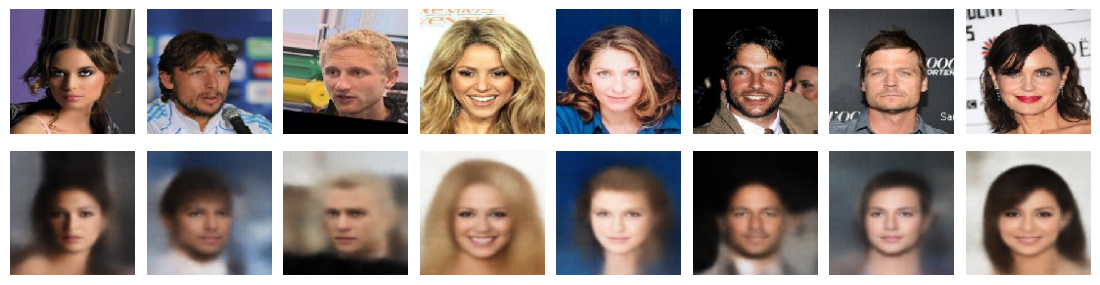

In [39]:
def plot_compare_VAE(images, add_noise=False):
    
    n_to_show = images.shape[0]

    if add_noise:
        encodings = VAE_encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = VAE_decoder.predict(encodings)

    else:
        reconst_images = VAE.predict(images)


    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
        #img = images[i].squeeze()
        img = images[i]
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img)
    plt.show()
                

plot_compare_VAE(example_images)     

### VAE advantages

First, we are going to compare the robustness of VAEs against noise, as we did with simple AEs

1/1 [==============================] - 0s 158ms/step


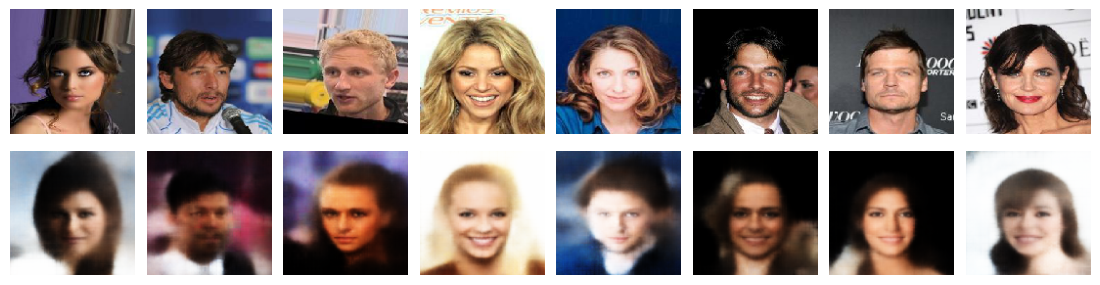

In [40]:
plot_compare_VAE(example_images, add_noise=True)  

The results are worse than in AEs, and this is caused by the fact that the points in the latent space are more concentrated, and the effect of the same distorsion is going to be much more noticiable. A perturbation really transforms the images

What if we try to decode random points in the latent space?

1/1 [==============================] - 0s 37ms/step


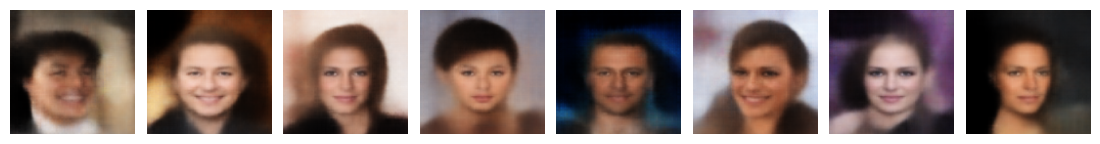

In [55]:
def VAE_generate_images_from_noise(n_to_show = 8): 
    reconst_images = VAE_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
            img = reconst_images[i].squeeze()
            sub = fig.add_subplot(1, n_to_show, i+1)
            sub.axis('off')        
            sub.imshow(img)
    plt.show()

VAE_generate_images_from_noise() 

These are clearly human faces, and in this area VAEs clearly outperfom simple AEs

### Latent space characteristics in VAEs

We are going to represent the histogram of 16 coefficients of 200 samples in the latent space. It can be seen that the distributions are approximately normal, as they should. The addition of the KL divergence is then justified

7/7 [==============================] - 0s 49ms/step


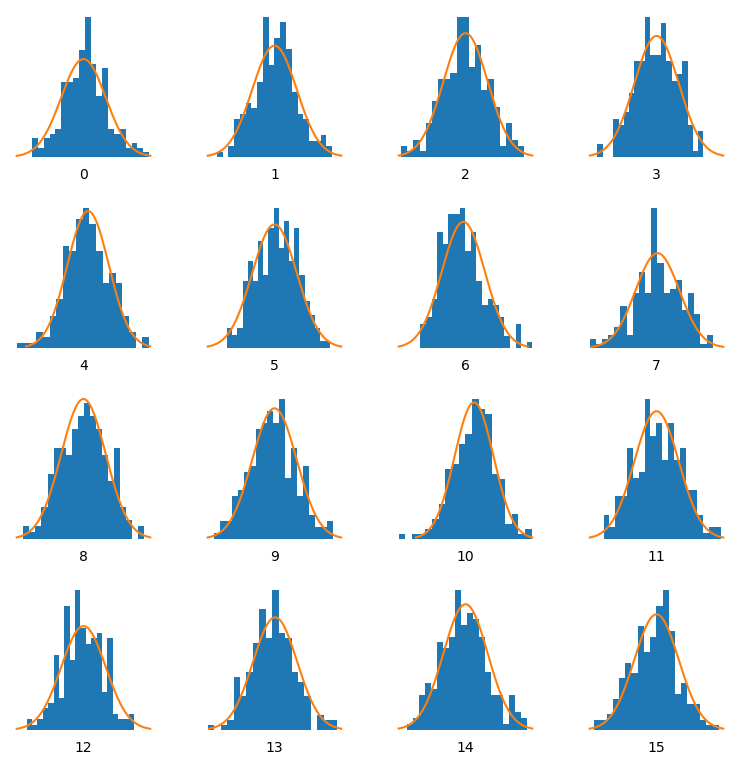

In [56]:
from scipy.stats import norm

z_test = VAE_encoder.predict(example_batch[:200])

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.3, wspace=0.3)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.15, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

The continuity of the latent space can be further demonstrated trying interpolation between two encoded images, as shown in the following example

1/1 [==============================] - 0s 94ms/step


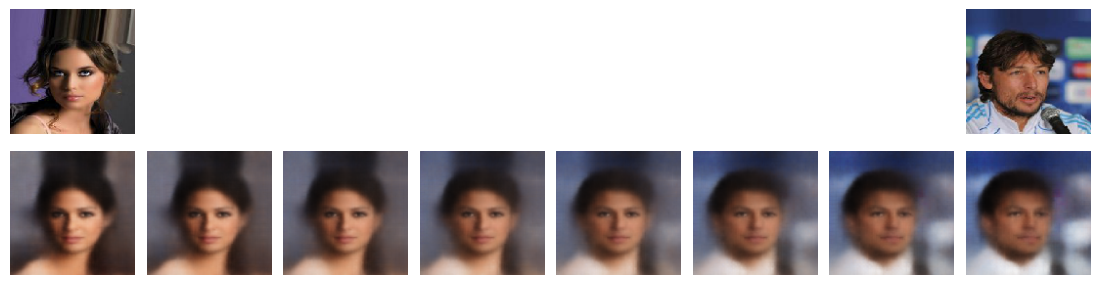

In [58]:
def VAE_linear_interpolation(images, n_to_show = 8):
    limit_images = images[0:2]

    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    left = limit_images[0]
    img=left.squeeze()
    sub = fig.add_subplot(2, n_to_show, 1)
    sub.axis('off')        
    sub.imshow(img)

    right = limit_images[1]
    img=right.squeeze()
    sub = fig.add_subplot(2, n_to_show, n_to_show)
    sub.axis('off')        
    sub.imshow(img)


    limit_encodings = VAE_encoder.predict(limit_images)
    #print(limit_encodings.shape)
    interp_encodings = np.zeros((n_to_show, limit_encodings.shape[1]))
    interp_encodings[0] = limit_encodings[0]
    interp_encodings[-1] = limit_encodings[-1]
    step_size = 1 / (interp_encodings.shape[0] - 1)
    for i in range(1, interp_encodings.shape[0] - 1):
        interpolation_factor = i * step_size
        interp_encodings[i] = (1 - interpolation_factor) * limit_encodings[0] + interpolation_factor * limit_encodings[-1]

    #print(interp_encodings.shape)
    
    interp_images = VAE_decoder.predict(interp_encodings)
    
    for i in range(n_to_show):
            img = interp_images[i].squeeze()
            sub = fig.add_subplot(2, n_to_show, n_to_show+i+1)
            sub.axis('off')        
            sub.imshow(img)
    plt.show()


VAE_linear_interpolation(example_images)

Finally, we can try some perturbation in one of the coefficients in the latent space, to see the effect in different dimensions

1/1 [==============================] - 0s 37ms/step


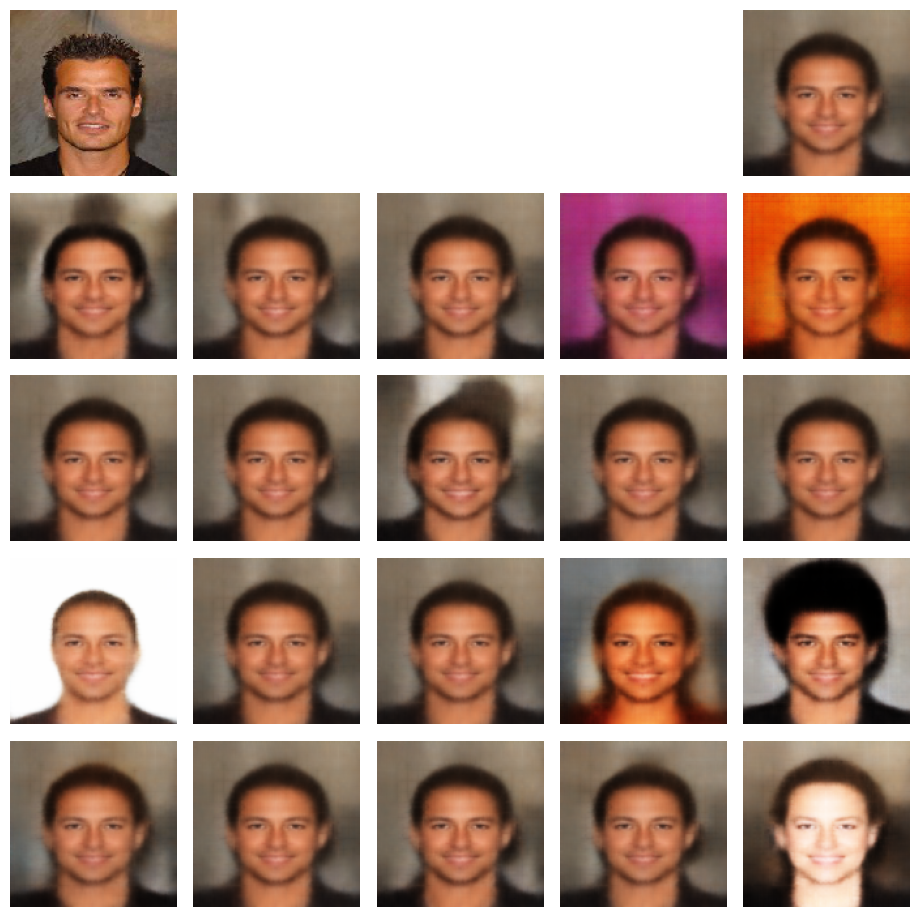

In [71]:
def VAE_distort_sample():
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    input_image = example_batch[:1]

    fig = plt.figure(figsize=(10, 12))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)
    img = input_image.squeeze()
    sub = fig.add_subplot(6, 5, 1)
    sub.axis('off')        
    sub.imshow(img)

    encoded_input = VAE_encoder.predict(input_image)
    output = VAE_decoder.predict(encoded_input)
    img = output.squeeze()
    sub = fig.add_subplot(6, 5, 5)
    sub.axis('off')        
    sub.imshow(img)

    for i in range(0,20):
            encoded_input2 = np.array(encoded_input)
            p = np.random.randint(0,200)
            encoded_input2[0][p] = encoded_input2[0][p] + 5
            output2 = VAE_decoder.predict(encoded_input2)
            img = output2.squeeze()
            sub = fig.add_subplot(6, 5 , i+6)
            sub.axis('off')        
            sub.imshow(img)
    plt.show()

VAE_distort_sample()